# Introduction

# Libraries and Modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', -1)
import numpy as np
import itertools

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("dark")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("GnBu_d")

import os, shutil
import cv2
import pytesseract
from PIL import Image
from scipy import ndimage
import swifter
from IPython.display import Image
import pydotplus
import pickle

In [ ]:
# import tensorflow as tf
# from keras import Model
# from keras.applications.resnet50 import ResNet50
# from keras.preprocessing import image
# from keras.applications.resnet50 import preprocess_input, decode_predictions
# from keras.layers import GlobalMaxPooling2D
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# from sklearn.metrics.pairwise import pairwise_distances
# from keras import models

## Py files

In [23]:
import preprocess as pre
# import images
import recommendation as reco
%reload_ext autoreload
%autoreload 2

In [5]:
!pwd

/Users/valmadrid/DataScienceBootcamp/Projects/Final Project/Predicting-PetFinder-Adoption-Rate


# Pre-processing

In [3]:
pets = pd.read_csv("pets.csv")
pets.dropna(axis=0, subset=["filename"], inplace=True)
pets = pre.drop_columns(pets, ["adoption_speed"])
pets.isna().sum()

pet_id                      0    
type                        0    
name                        1197 
age                         0    
breed1                      0    
breed1_desc                 4    
breed2                      0    
breed2_desc                 10519
gender                      0    
color1                      0    
color1_desc                 0    
color2                      0    
color2_desc                 4340 
color3                      0    
color3_desc                 10376
maturity_size               0    
fur_length                  0    
vaccinated                  0    
dewormed                    0    
sterilized                  0    
health                      0    
quantity                    0    
fee                         0    
state                       0    
state_desc                  0    
rescuer_id                  0    
video_count                 0    
photo_count                 0    
filename                    0    
description   

In [4]:
pets.fillna("", inplace=True)
pets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14652 entries, 0 to 14992
Data columns (total 34 columns):
pet_id                      14652 non-null object
type                        14652 non-null int64
name                        14652 non-null object
age                         14652 non-null int64
breed1                      14652 non-null int64
breed1_desc                 14652 non-null object
breed2                      14652 non-null int64
breed2_desc                 14652 non-null object
gender                      14652 non-null int64
color1                      14652 non-null int64
color1_desc                 14652 non-null object
color2                      14652 non-null int64
color2_desc                 14652 non-null object
color3                      14652 non-null int64
color3_desc                 14652 non-null object
maturity_size               14652 non-null int64
fur_length                  14652 non-null int64
vaccinated                  14652 non-null int64
de

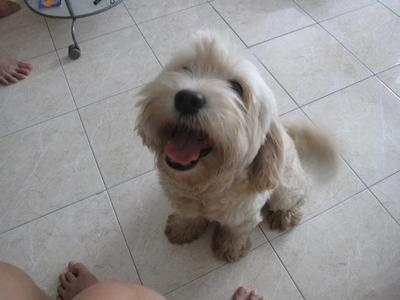

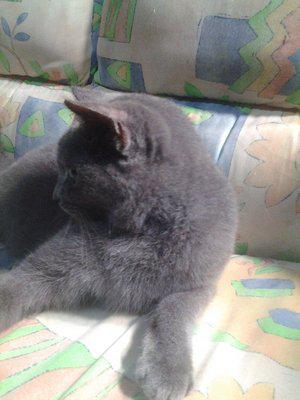

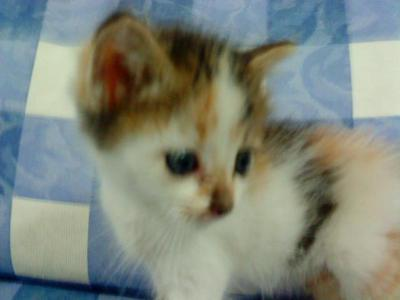

In [34]:
images_folder_path = "dataset/petfinder-adoption-prediction/train_images/"
for i in range(3):
    j = list(pets.index)[np.random.randint(low=0, high=pets.shape[0])]
    pre.get_image(images_folder_path, pets.filename[j])

In [5]:
dogs = pets.query("type==1")
cats = pets.query("type==2")

# pickle.dump(dogs, open("df_dogs.pkl", "wb"))
# pickle.dump(cats, open("df_cats.pkl", "wb"))

In [24]:
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
base_model.trainable = False
model = models.Sequential([base_model, GlobalMaxPooling2D()])
model.summary()
# pickle.dump(model, open("image_reco.pkl", "wb"))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


array([2.734817 , 5.3286166, 6.38519  , ..., 6.3259344, 4.6416216,
       6.639138 ], dtype=float32)

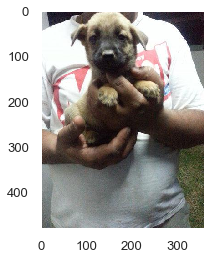

In [44]:
i = np.random.randint(low=0, high=pets.shape[0])

display(images.get_embedding(model, pets.filename.loc[i],images_folder_path))

plt.imshow(cv2.cvtColor(images.load_image(pets, i, images_folder_path), cv2.COLOR_BGR2RGB));

In [ ]:
%%time
map_embeddings_dogs = dogs.filename.swifter.apply(lambda img: get_embedding(model, img,images_folder_path))
data_embs_dogs = map_embeddings_dogs.apply(pd.Series)

In [ ]:
%%time
map_embeddings_cats = cats.filename.swifter.apply(lambda img: get_embedding(model, img,images_folder_path))
data_embs_cats = map_embeddings_cats.apply(pd.Series)

In [ ]:
to_include = ["type", "gender", "breed1", "breed2", "color1", "color2", "color3", "state"]

df_data_embs_dogs = pd.concat([data_embs_dogs, dogs[to_include]], axis=1)
df_data_embs_cats = pd.concat([data_embs_cats, cats[to_include]], axis=1)

df_cosine_dogs = 1-pairwise_distances(df_data_embs_dogs, metric='cosine')
df_cosine_cats = 1-pairwise_distances(df_data_embs_cats, metric='cosine')

# pickle.dump(df_cosine_dogs, open("df_cosine_dogs.pkl", "wb"))
# pickle.dump(df_cosine_cats, open("df_cosine_cats.pkl", "wb"))

# Test Model

Meet.. 

Name : Yoo Hee (Thanx Atye)
Breed : Domestic Medium Hair 
Location : Selangor
Description : He likes to play so much, and sleep with people. sometimes he would kiss on the cheek :)


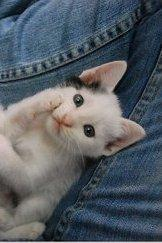

Please check out these listings as well: 


Name : Marshmallow
Breed : Domestic Medium Hair 
Location : Kuala Lumpur
Description : Adorable,Very lovely, gentle n manja
Note: Cosine similarity =  0.999987379468541


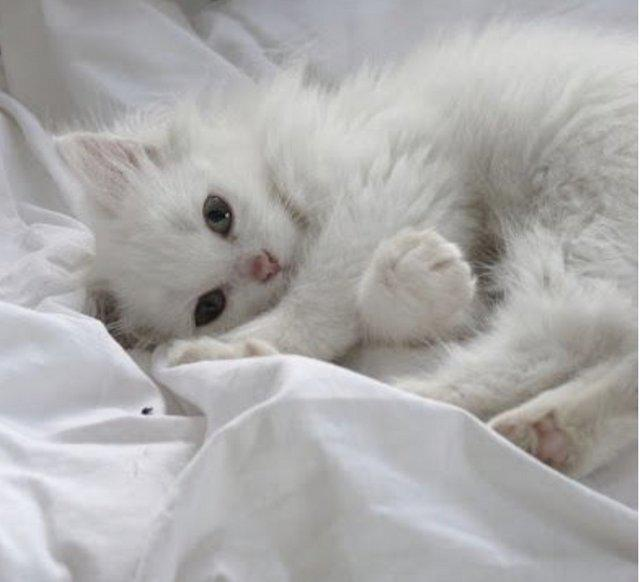

Name : 
Breed : Domestic Short Hair 
Location : Selangor
Description : Kitten For Adoption 🐈
Note: Cosine similarity =  0.9999871067611683


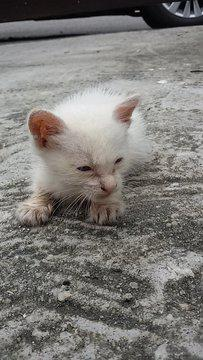

In [41]:
random = np.random.randint(low=0, high=len(pets))
reco.get_reco(list(pets.index)[random], pets, 2)